In [1]:
import pandas as pd

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import pickle
from pickle import dump

import matplotlib.pyplot as plt

In [8]:
#Re-create the CSV files containing experiment data (8leg)
# import utils
# filename = "8legs_new300LH_NT2_RF1.csv"
# legList = [8]
# utils.createSamplesCSVfromGsheets(legList, filename, k0type="simulated")

In [9]:
#Re-create the CSV files containing experiment data (68leg)
# import utils
# filename = "68legs_NT2_RF1.csv"
# leg = 68
# utils.createSamplesCSVfromGsheets(leg, filename, k0type="simulated", multiLeg=True)

In [10]:
#Re-create the CSV files containing experiment data (246810leg)
# import utils
# filename = "246810legs_NT2_RF1_wlegs.csv"
# leg = 246810
# utils.createSamplesCSVfromGsheets(leg, filename, k0type="simulated", multiLeg=True)

In [4]:
#Re-create the CSV files containing experiment data (246leg)
# import utils
# filename = "246legs_NT2_RF1_wlegs_v4.csv"
# leg = 246
# utils.createSamplesCSVfromGsheets(leg, filename, k0type="simulated", multiLeg=True)

In [2]:
dataframe = pd.read_csv("246legs_NT2_RF1_wlegs_v4.csv", header=None) #Last 10 columns are f1, f2, ..., f10 outputs
num_cols = len(dataframe.columns)

#Shuffling
dataframe = dataframe.sample(frac = 1)
dataset = dataframe.values

#Scaling
inp_scaler = StandardScaler()
out_scaler = StandardScaler()
# inp_scaler.fit(dataset[:,0:num_cols-10]) #w legs
# out_scaler.fit(dataset[:,num_cols-10:]) #w legs
inp_scaler.fit(dataset[:,0:2]) #wo legs
out_scaler.fit(dataset[:,3:]) #wo legs
# scaled_inputs = inp_scaler.transform(dataset[:,0:num_cols-10]) #w legs
# scaled_outputs = out_scaler.transform(dataset[:,num_cols-10:]) #w legs
scaled_inputs = inp_scaler.transform(dataset[:,0:2]) #wo legs
scaled_outputs = out_scaler.transform(dataset[:,3:]) #wo legs

dump(inp_scaler, open('inp_scaler246_v4_wolegs.pkl', 'wb'))
dump(out_scaler, open('out_scaler246_v4_wolegs.pkl', 'wb'))

In [3]:
num_exps = dataset.shape[0]
train_exps = round(num_exps*0.90)

#Scaling
X_train = scaled_inputs[0:train_exps] #k0, dmax
Y_train = scaled_outputs[0:train_exps] #f01, f02, ..., f10
X_test = scaled_inputs[train_exps:]
Y_test = scaled_outputs[train_exps:]

In [4]:
#Define Keras regression model
def regression_model():
    model = Sequential()
    model.add(Dense(12, input_dim=2, kernel_initializer='normal', activation='relu'))
    model.add(Dense(5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [5]:
# Train the estimator
estimator = regression_model()
hist = estimator.fit(X_train, Y_train, epochs=2000, batch_size=20, verbose=1, shuffle=False, validation_data=(X_test,Y_test))

 val_loss: 0.0022
Epoch 1816/2000
810/810 [==============================] - 0s 79us/sample - loss: 0.0024 - val_loss: 0.0022
Epoch 1817/2000
810/810 [==============================] - 0s 81us/sample - loss: 0.0023 - val_loss: 0.0022
Epoch 1818/2000
810/810 [==============================] - 0s 83us/sample - loss: 0.0024 - val_loss: 0.0022
Epoch 1819/2000
810/810 [==============================] - 0s 83us/sample - loss: 0.0024 - val_loss: 0.0022
Epoch 1820/2000
810/810 [==============================] - 0s 81us/sample - loss: 0.0024 - val_loss: 0.0022
Epoch 1821/2000
810/810 [==============================] - 0s 77us/sample - loss: 0.0024 - val_loss: 0.0022
Epoch 1822/2000
810/810 [==============================] - 0s 80us/sample - loss: 0.0024 - val_loss: 0.0022
Epoch 1823/2000
810/810 [==============================] - 0s 79us/sample - loss: 0.0024 - val_loss: 0.0022
Epoch 1824/2000
810/810 [==============================] - 0s 82us/sample - loss: 0.0024 - val_loss: 0.0022
Epoch 1825

In [6]:
estimator.save("246leg_v4_NN_model_NT2_random_RF1_scaled_wolegs.h5") #UNCOMMENT ONLY IF WE MADE NECESSARY CHANGES

Training loss: 0.002323487135409205
Test loss: 0.002179199286426107


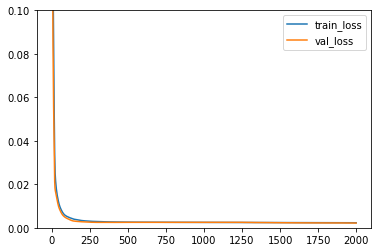

In [7]:
# Get train params
print ("Training loss: {}".format(hist.history['loss'][-1]))
print ("Test loss: {}".format(hist.history['val_loss'][-1]))
plt.ylim(0,1e-1)
plt.plot (hist.history['loss'])
plt.plot (hist.history['val_loss'])
plt.legend(["train_loss","val_loss"])

In [10]:
# estimator = keras.models.load_model("8leg_NN_model_NT2_300LH_scaled.h5")
test_sample = np.asarray([1.96E-4, 23.26]).reshape(1,2)

#Scaling
test_sample_scaled = inp_scaler.transform(test_sample)
scaled_nonlin_force = estimator.predict (test_sample_scaled)
nonlin_force = out_scaler.inverse_transform(scaled_nonlin_force)

print (nonlin_force)

[[0.00026149 0.00052593 0.00080858 0.00113506 0.00148779 0.00194422
  0.002502   0.00334487 0.00434916 0.00536852]]


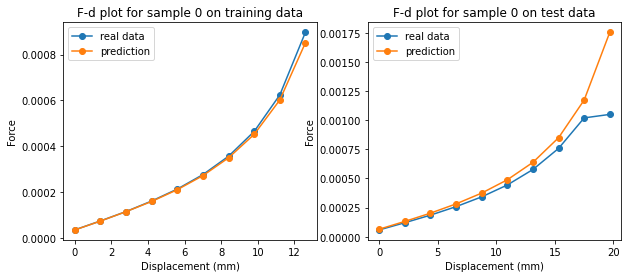

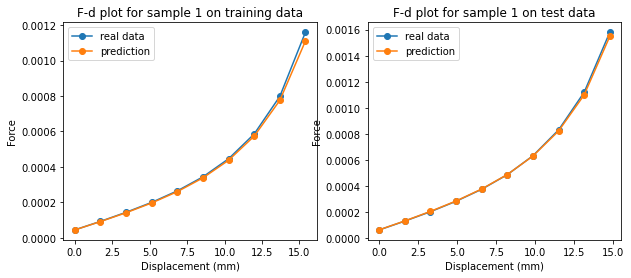

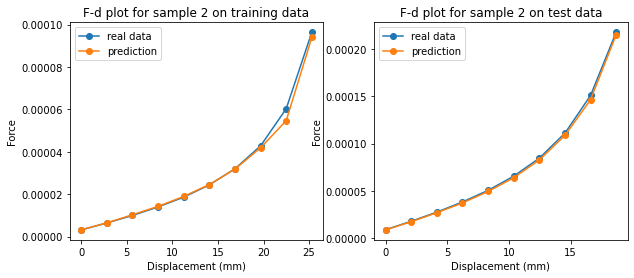

In [11]:
#Scaling
displacement_train = np.linspace(0,dataset[0:train_exps,1],10).T
scaled_prediction_train = estimator.predict(X_train[0:3,:])
prediction_train = out_scaler.inverse_transform(scaled_prediction_train)
displacement_test = np.linspace(0,dataset[train_exps:,1],10).T
scaled_prediction_test = estimator.predict(X_test[0:3,:])
prediction_test = out_scaler.inverse_transform(scaled_prediction_test)

#Run:
for i in range(3):
    fig = plt.figure(figsize = (10,4))
    axs = plt.subplot(121)
    axs.plot(displacement_train[i], dataset[i,2:], '-o', displacement_train[i], prediction_train[i], '-o')
    axs.set(xlabel="Displacement (mm)", ylabel="Force",
            title="F-d plot for sample {} on training data".format(i))
    axs.legend(["real data","prediction"])
    axs = plt.subplot(122)
    axs.plot(displacement_test[i], dataset[i+train_exps,2:], '-o', displacement_test[i], prediction_test[i], '-o')
    axs.set(xlabel="Displacement (mm)", ylabel="Force", title="F-d plot for sample {} on test data".format(i))
    axs.legend(["real data","prediction"])